In [94]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [95]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF

In [96]:
import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()

In [97]:
df = pd.read_csv('archivos/dataset_trabajado.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)

df

Title Document Type  \
0     BIOREMEDIATION OF SULFATE IN WATER ENVIRONMENT...       Article   
1     Combining slow-release fertilizer and plastic ...       Article   
2     Carbon emissions in China's steel industry fro...       Article   
3     Bioenergy recovery and carbon emissions benefi...       Article   
4     Sustainability evaluation of C3MR natural gas ...       Article   
...                                                 ...           ...   
1608  An analysis of energy consumption and carbon f...       Journal   
1609  Downscaling consumption to universal basic inc...       Journal   
1610  Decomposing the carbon footprints of multinati...       Journal   
1611  Single-item substitutions can substantially re...       Journal   
1612  Does telemedicine reduce the carbon footprint ...       Journal   

                                                Authors  \
0                                Yadav G.S.; Ghosh P.K.   
1     Han X.; Dang P.; Liao L.; Song F.; Zhang M.; Z...   
2     Song X.; Du S.; Deng C.; Shen P.; Xie M.; Zhao...   
3     Wang H.; Fu X.; Huang H.; Shen D.; Fan D.; Zhu...   
4     Hareem M.; Raza F.; Kazmi B.; Ghauri R.; Zafar...   
...                                                 ...   
1608  Kohli; Varun; Chakravarty; Sombuddha; Chamola;...   
1609  Kalaniemi; Salla; Ottelin; Juudit; Heinonen; J...   
1610  Yan; Yunfeng; Li; Xiyuan; Wang; Ran; Zhao; Zho...   
1611  Rose; Donald; Willits-Smith; Amelia M; Heller;...   
1612         Purohit; Amy; Smith; James; Hibble; Arthur   

                                          Source title  Volume  Year  \
0     Journal of Solid Waste Technology and Management    50.0  2024   
1            Journal of Environmental Sciences (China)   147.0  2025   
2            Journal of Environmental Sciences (China)   148.0  2025   
3            Journal of Environmental Sciences (China)   148.0  2025   
4      Journal of Industrial and Engineering Chemistry   137.0  2024   
...                                                ...     ...   ...   
1608               Digital Communications and Networks     9.0  2023   
1609                    Environmental Science & Policy   114.0  2020   
1610           Structural Change and Economic Dynamics    66.0  2023   
1611        The American Journal of Clinical Nutrition   115.0  2022   
1612                         Future Healthcare Journal     8.0  2021   

     Page start Page end                                            DOI  \
0           430      440              10.5276/JSWTM/ISWMAW/501/2024.430   
1           359      369                      10.1016/j.jes.2023.12.001   
2           650      664                      10.1016/j.jes.2023.04.027   
3           321      335                      10.1016/j.jes.2023.08.022   
4           619      636                     10.1016/j.jiec.2024.05.041   
...         ...      ...                                            ...   
1608         79       89     https://doi.org/10.1016/j.dcan.2022.06.017   
1609        377      383   https://doi.org/10.1016/j.envsci.2020.09.006   
1610         13       28  https://doi.org/10.1016/j.strueco.2023.03.011   
1611        378      387           https://doi.org/10.1093/ajcn/nqab338   
1612        e85      e91          https://doi.org/10.7861/fhj.2020-0080   

                                                   Link      ISSN  \
0     https://www.scopus.com/inward/record.uri?eid=2...  10881697   
1     https://www.scopus.com/inward/record.uri?eid=2...  10010742   
2     https://www.scopus.com/inward/record.uri?eid=2...  10010742   
3     https://www.scopus.com/inward/record.uri?eid=2...  10010742   
4     https://www.scopus.com/inward/record.uri?eid=2...  1226086X   
...                                                 ...       ...   
1608  https://www.sciencedirect.com/science/article/...  23528648   
1609  https://www.sciencedirect.com/science/article/...  14629011   
1610  https://www.sciencedirect.com/science/article/...  0954349X   
1611  ht

In [98]:
palabras_vacias = [linea.rstrip('\n') for linea in open('archivos/english.txt')]
palabras_vacias.extend(['the','The','I','If', 'negative', 'Negative', 'Nothing', 'nothing'])
len(palabras_vacias)

1306

In [99]:
import re 

def processing_keywords(keywords):
    return [keyword.strip() for keyword in keywords.split(';')]

def unificated_keywords(keywords_list):
   new_list = []

   for i in range(len(keywords_list)):
      new_list.extend(keywords_list[i])

   return new_list

def remove_sw(t): 
  tokens = t.strip().split(' ')
  tokens = [token for token in tokens if token not in palabras_vacias]
  tout = ' '.join(tokens).strip()
  return tout 

def clean_text(t): 
  t = str(t) 
  t = re.sub(r'\d+',' ',t)
  t = re.sub(r'[^\w\n]',' ',t)
  t = re.sub(r'\s\s+',' ',t)
  t = t.lower()
  t = t.strip()
  return t

In [100]:
corpus_title = df['Title'].to_list()
len(corpus_title)

1613

In [101]:
corpus_abstract = df['Abstract'].to_list()
len(corpus_abstract)

1613

In [102]:
df['Keywords Processed'] = df['Keywords'].apply(processing_keywords)
corpus_keywords = df['Keywords Processed'].tolist()
corpus_unif_keywords = unificated_keywords(corpus_keywords)
len(corpus_unif_keywords)

8700

In [103]:
stop_words = [linea.rstrip('\n') for linea in open('archivos/english.txt')]
stop_words.extend(['the','The','I','If', 'negative', 'Negative', 'Nothing', 'nothing'])
len(stop_words)

1306

In [104]:
def crear_nubes(col_cluster, col_text, nc=10):
  gc = 2
  gr = int(nc/gc)
  wcwidth  = 1600
  wcheight = 800
  fig = plt.figure(figsize = (30,50))
  fig.suptitle('Análisis con {}'.format(col_cluster), fontsize=44)

  for i in range(nc):
    dfs = df[df[col_cluster] == i][col_text]
    labels =  df[df[col_cluster] == i][str(col_cluster) + ' Label']
    label = labels.iloc[0]
    texto = ' '.join(map(str,dfs.tolist()))
    wc = WordCloud(width=wcwidth, height=wcheight,colormap="Paired").generate(texto)
    ax = fig.add_subplot(gr,gc,i+1)
    ax.imshow(wc,interpolation='bilinear')
    ax.axis('off')
    ax.set_title('{} - {}'.format(col_cluster, str(label)))
    ax.title.set_size(20)
  return fig

In [105]:
corpus_title = [clean_text(t) for t in corpus_title]
corpus_title = [remove_sw(t) for t in corpus_title]
df['Title Text'] = corpus_title

## KMeans

### Columna Title

In [106]:
tfidf_vectorizer = TfidfVectorizer(strip_accents = 'unicode', stop_words = 'english', lowercase = True)
dtm_tfidf = tfidf_vectorizer.fit_transform(corpus_title)

In [107]:
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(dtm_tfidf)

c:\Users\keysw\miniconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=10, random_state=0)

In [108]:
labels = kmeans.labels_
set(labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

### Evaluación por Silhouette Score (Coeficiente de Silueta)

In [109]:
silhouette_avg = silhouette_score(dtm_tfidf, labels)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.008606569240749441


### Topicos

In [110]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names_out()

for i in range(num_clusters):
    cluster_words = []
    for ind in order_centroids[i, :10]:
        word = terms[ind]
        cluster_words.append(word)
    print("Cluster {}: {}".format(i, ', '.join(cluster_words)))

Cluster 0: based, climate, green, concrete, performance, study, properties, waste, analysis, change
Cluster 1: environmental, sustainability, impact, economic, assessment, curve, impacts, food, kuznets, based
Cluster 2: emissions, greenhouse, gas, carbon, study, reduction, reducing, chain, china, dioxide
Cluster 3: sustainable, development, green, construction, carbon, practices, goals, energy, environmental, based
Cluster 4: hydrogen, bio, production, based, fuel, electrolysis, carbon, reforming, polymers, environmental
Cluster 5: carbon, footprints, production, water, china, emission, study, india, based, rice
Cluster 6: footprint, carbon, analysis, reduction, food, assessment, energy, impact, study, based
Cluster 7: life, cycle, assessment, environmental, carbon, production, footprint, comparative, impact, sustainability
Cluster 8: ecological, evidence, energy, countries, economic, renewable, environmental, footprint, quality, growth
Cluster 9: energy, renewable, efficiency, learnin

In [111]:
kmeans_labels = { 0: 'Estudio del Cambio Climatico', 1: 'Impacto del Medio Ambiente en la Economía', 
                 2: 'Reducción de Emisiones de Dioxido de Carbono en China', 3: 'Metas para Desarrollo Sostenible', 
                 4: 'Relación en la Fabricación de Materiales con el Medio Ambiente', 
                 5: 'Estudio de Emisiones en Países de Asía', 
                 6: 'Estudios para la Reducción del Impacto Energetico', 
                 7: 'Ciclo de Vida de las Empresas Productoras', 
                 8: 'Crecimiento de los Países y sus Energías Renovables', 
                 9: 'Aprendizaje para la Eficiencia de las Energías Renovables'}

df['KMeans'] = labels
df['KMeans Label'] = df['KMeans'].map(kmeans_labels)

df

Title Document Type  \
0     BIOREMEDIATION OF SULFATE IN WATER ENVIRONMENT...       Article   
1     Combining slow-release fertilizer and plastic ...       Article   
2     Carbon emissions in China's steel industry fro...       Article   
3     Bioenergy recovery and carbon emissions benefi...       Article   
4     Sustainability evaluation of C3MR natural gas ...       Article   
...                                                 ...           ...   
1608  An analysis of energy consumption and carbon f...       Journal   
1609  Downscaling consumption to universal basic inc...       Journal   
1610  Decomposing the carbon footprints of multinati...       Journal   
1611  Single-item substitutions can substantially re...       Journal   
1612  Does telemedicine reduce the carbon footprint ...       Journal   

                                                Authors  \
0                                Yadav G.S.; Ghosh P.K.   
1     Han X.; Dang P.; Liao L.; Song F.; Zhang M.; Z...   
2     Song X.; Du S.; Deng C.; Shen P.; Xie M.; Zhao...   
3     Wang H.; Fu X.; Huang H.; Shen D.; Fan D.; Zhu...   
4     Hareem M.; Raza F.; Kazmi B.; Ghauri R.; Zafar...   
...                                                 ...   
1608  Kohli; Varun; Chakravarty; Sombuddha; Chamola;...   
1609  Kalaniemi; Salla; Ottelin; Juudit; Heinonen; J...   
1610  Yan; Yunfeng; Li; Xiyuan; Wang; Ran; Zhao; Zho...   
1611  Rose; Donald; Willits-Smith; Amelia M; Heller;...   
1612         Purohit; Amy; Smith; James; Hibble; Arthur   

                                          Source title  Volume  Year  \
0     Journal of Solid Waste Technology and Management    50.0  2024   
1            Journal of Environmental Sciences (China)   147.0  2025   
2            Journal of Environmental Sciences (China)   148.0  2025   
3            Journal of Environmental Sciences (China)   148.0  2025   
4      Journal of Industrial and Engineering Chemistry   137.0  2024   
...                                                ...     ...   ...   
1608               Digital Communications and Networks     9.0  2023   
1609                    Environmental Science & Policy   114.0  2020   
1610           Structural Change and Economic Dynamics    66.0  2023   
1611        The American Journal of Clinical Nutrition   115.0  2022   
1612                         Future Healthcare Journal     8.0  2021   

     Page start Page end                                            DOI  \
0           430      440              10.5276/JSWTM/ISWMAW/501/2024.430   
1           359      369                      10.1016/j.jes.2023.12.001   
2           650      664                      10.1016/j.jes.2023.04.027   
3           321      335                      10.1016/j.jes.2023.08.022   
4           619      636                     10.1016/j.jiec.2024.05.041   
...         ...      ...                                            ...   
1608         79       89     https://doi.org/10.1016/j.dcan.2022.06.017   
1609        377      383   https://doi.org/10.1016/j.envsci.2020.09.006   
1610         13       28  https://doi.org/10.1016/j.strueco.2023.03.011   
1611        378      387           https://doi.org/10.1093/ajcn/nqab338   
1612        e85      e91          https://doi.org/10.7861/fhj.2020-0080   

                                                   Link      ISSN  \
0     https://www.scopus.com/inward/record.uri?eid=2...  10881697   
1     https://www.scopus.com/inward/record.uri?eid=2...  10010742   
2     https://www.scopus.com/inward/record.uri?eid=2...  10010742   
3     https://www.scopus.com/inward/record.uri?eid=2...  10010742   
4     https://www.scopus.com/inward/record.uri?eid=2...  1226086X   
...                                                 ...       ...   
1608  https://www.sciencedirect.com/science/article/...  23528648   
1609  https://www.sciencedirect.com/science/article/...  14629011   
1610  https://www.sciencedirect.com/science/article/...  0954349X   
1611  ht

<Axes: >

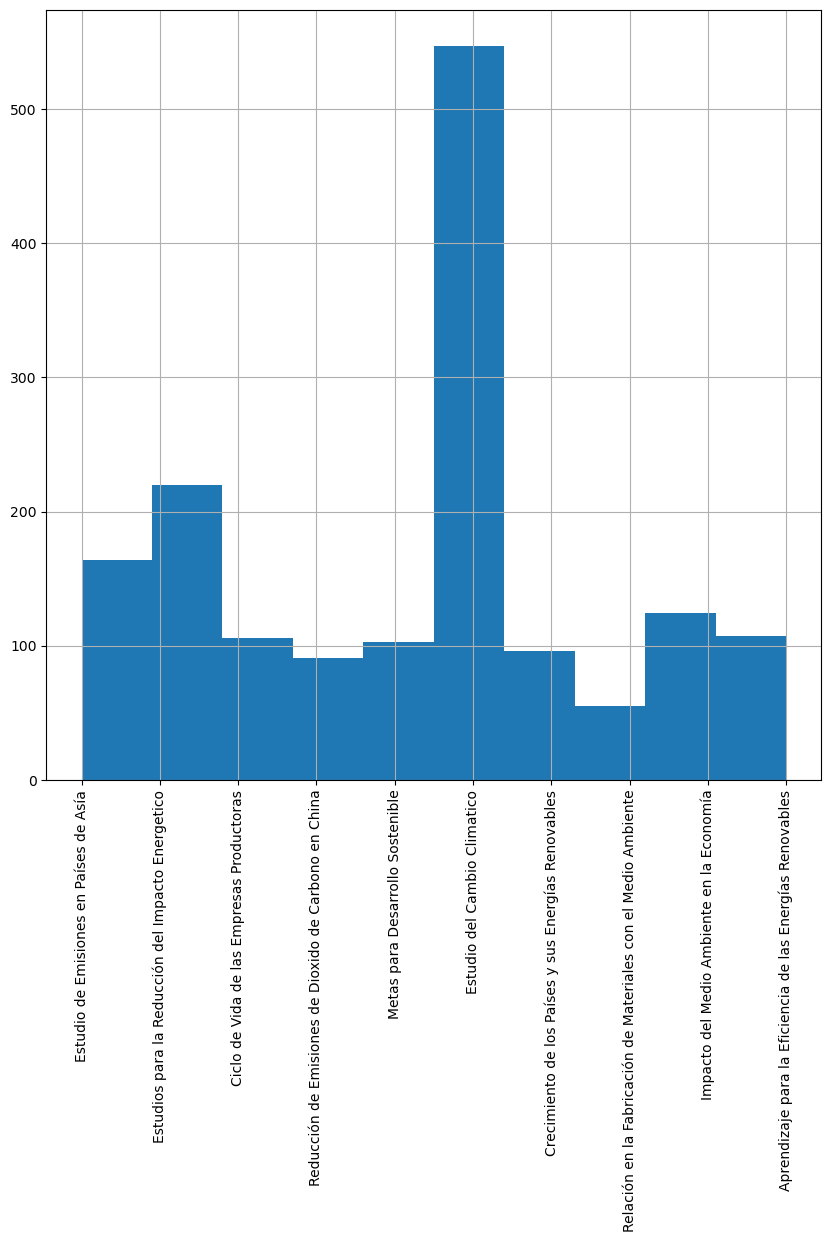

In [112]:
df['KMeans Label'].hist(xrot=90, figsize = (10,10))

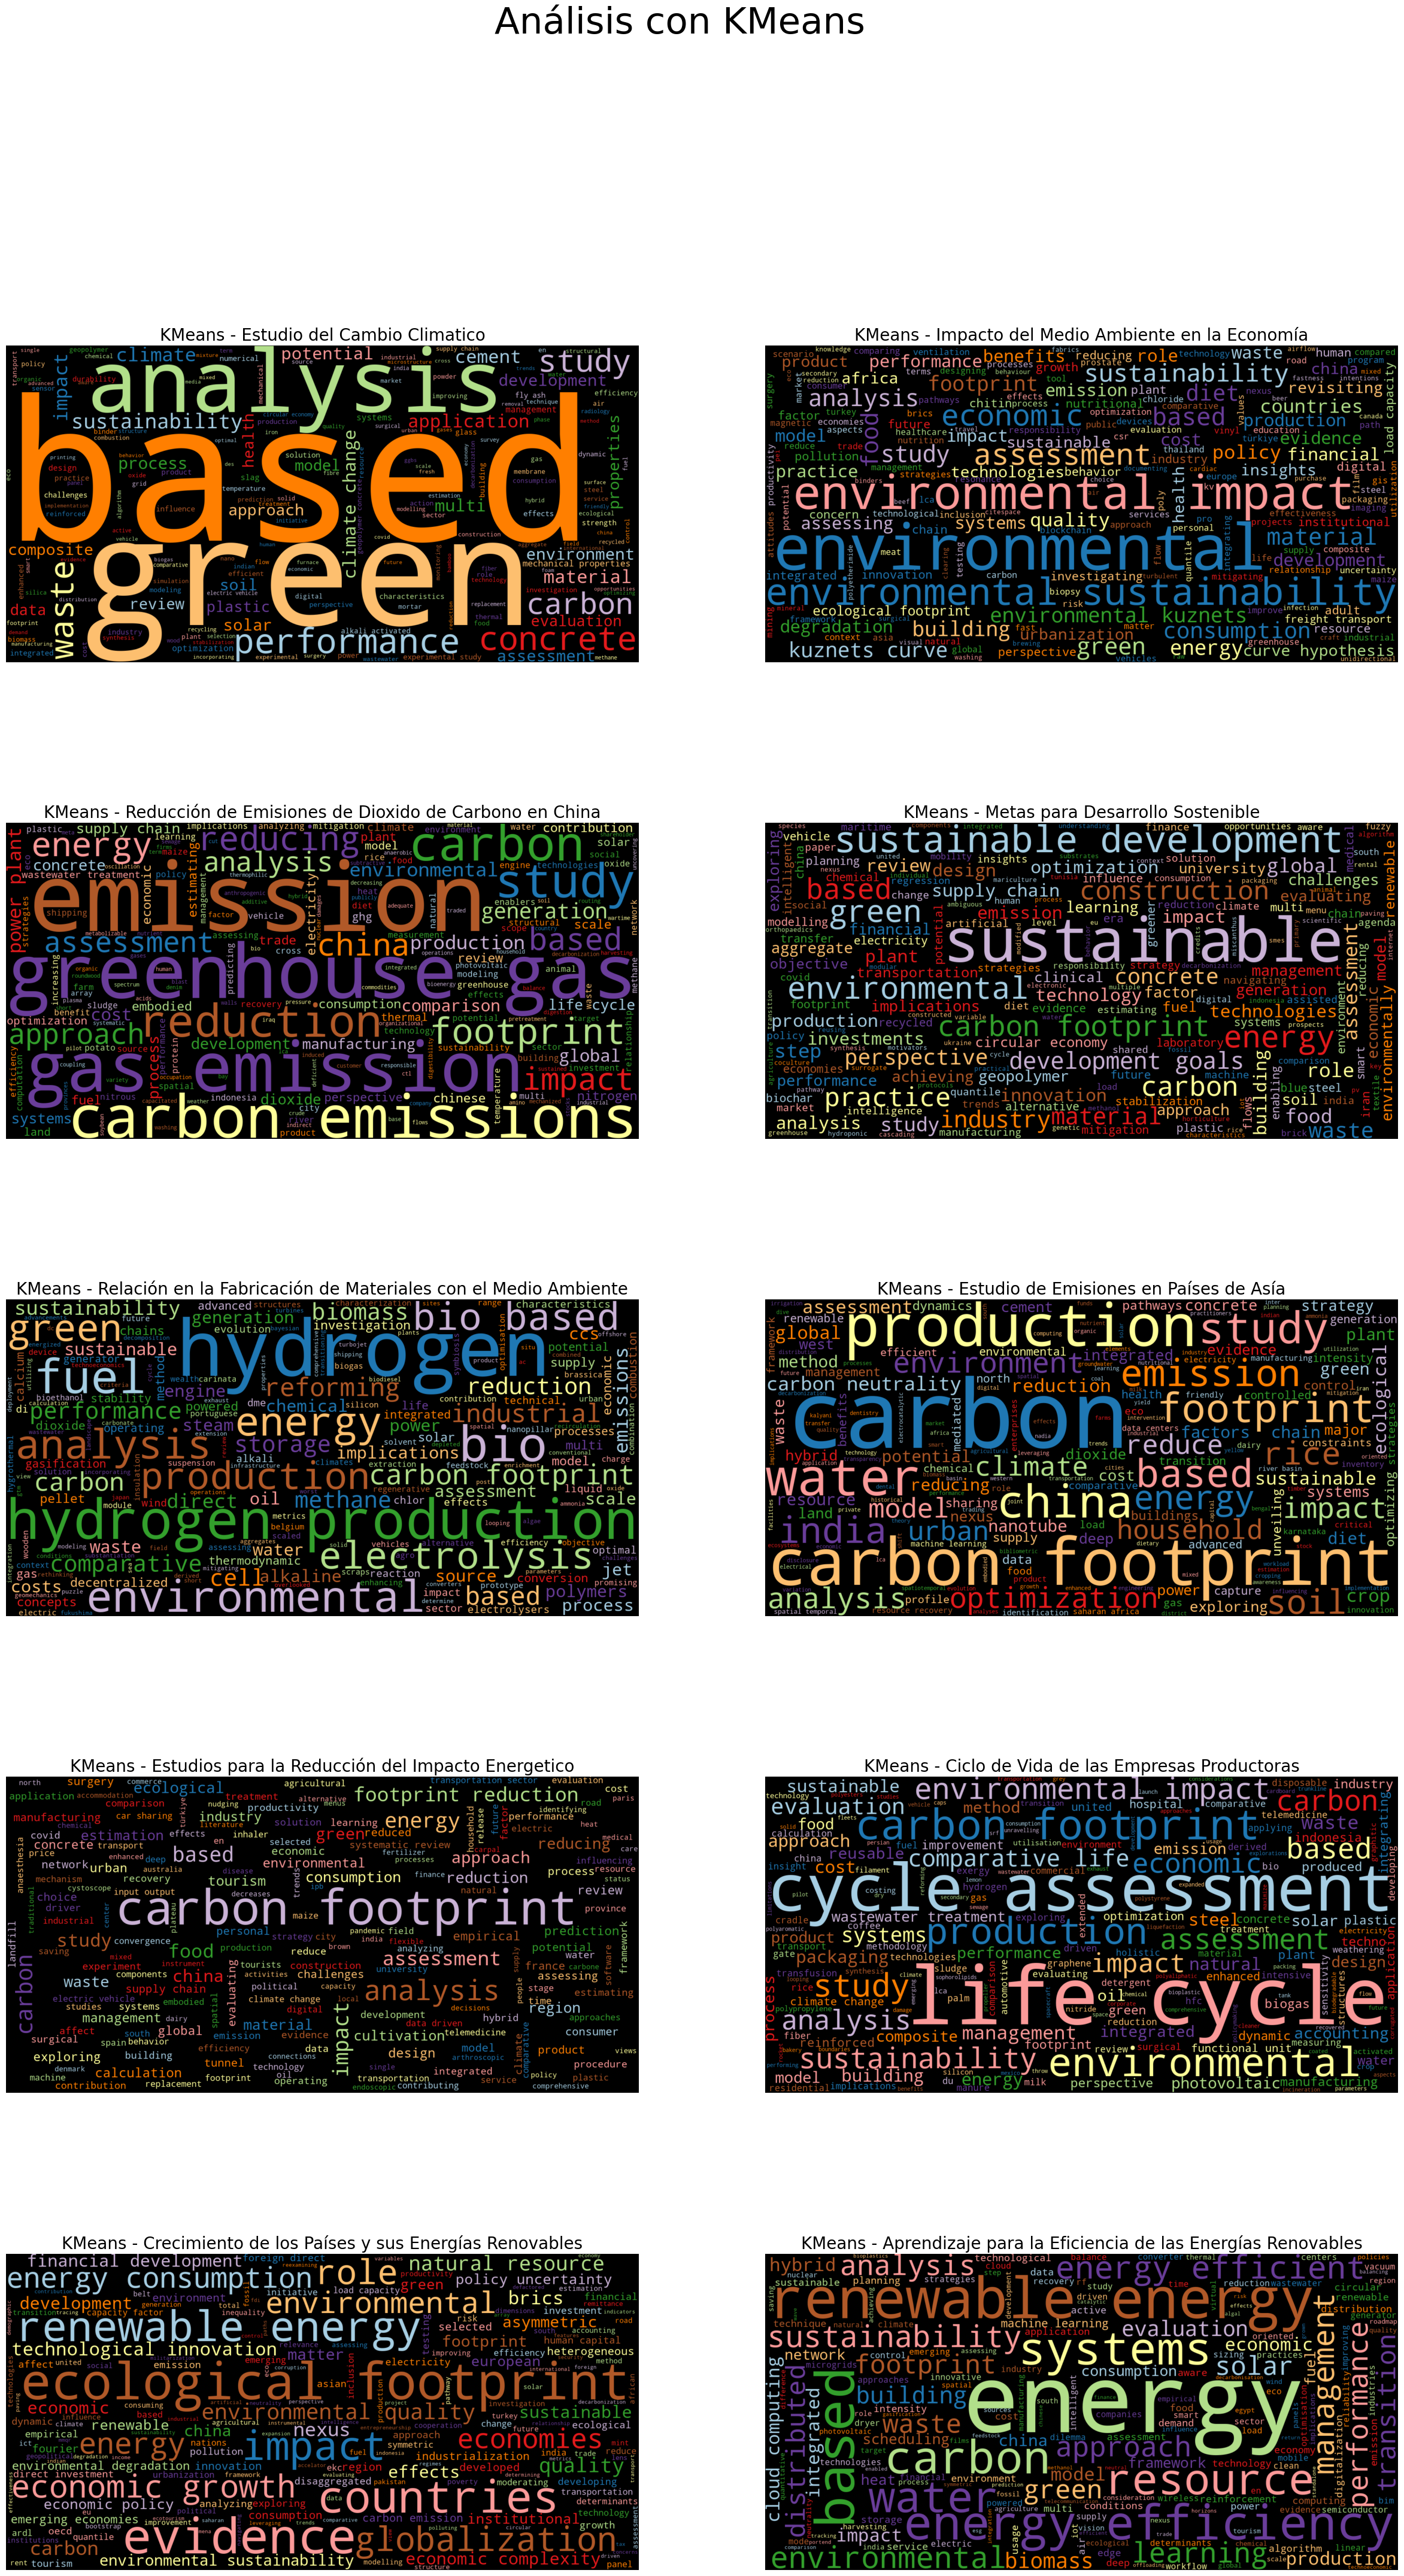

In [113]:
fig = crear_nubes('KMeans', 'Title Text', num_clusters)
plt.show()